Fitting the mean and variance of Praesepe.

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

Load the Praesepe data.

In [683]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
logp = np.log10(pr.prot[m])
err = .434
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(errp))*np.log10(650*1e6)

Add the Sun.

In [684]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, np.array([.0001])))

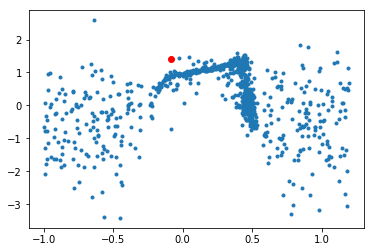

In [687]:
# Now augment the data with hot and cool stars.
nhot, ncool = 150, 150
logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, -.3, nhot), np.random.uniform(.58, 1.2, ncool)))
logp_aug = np.concatenate((logp_sun, np.random.randn(nhot)*1 - .5, np.random.randn(ncool)*1 - .5))
log_age_aug = np.concatenate((log_age_sun, np.ones(nhot)*np.log10(650*1e6), np.ones(ncool)*np.log10(650*1e6)))
logp_err_aug = np.concatenate((logp_err_sun, np.ones(nhot)*err, np.ones(ncool)*err))

plt.plot(logbprp_aug, logp_aug, ".")
plt.plot(sun_color, sun_prot, "ro")

In [688]:
def model(p, log_c, log_age):
    return np.polyval(p[:20], log_c) + p[21]*log_age

def variance(p, log_c, period_err):
    return (period_err + np.polyval(p[20:], log_c))**2

In [689]:
def lnlike(p, log_c, log_p, alge, period_err):
    mod = model(p, x)
    return np.sum(-.5 * (mod - y)**2/var - .5*np.log(2*np.pi*var))

def nll(p, x, y, yerr):
    mod = model(p, x)
    var = variance(p, x, yerr)
    return np.sum((-.5 * (mod - y)**2/var - .5*np.log(2*np.pi*var))*-1)

Initial guess

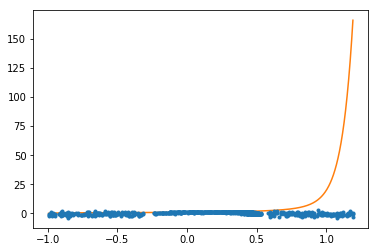

In [620]:
plt.errorbar(logbprp, logp, yerr=logp_err, fmt=".");

p0 = [9.34300279e-01, 4.04932557e-01, -3.08618712e+00, 4.95535468e+01,
      -7.33724799e+01, -2.08853506e+02, .1, .1, .1, .1,
      2.85311356e+02, 7.09812311e-02, 2.02599092e-01, 1, .1, .1, .1, .1]
p0 = np.ones(23)

x = np.linspace(min(logbprp), max(logbprp), 1000)
plt.plot(x, model(p0, x))

In [621]:
results = sco.minimize(nll, p0, args=(logbprp, logp, logp_err))
print(results.x)

[-4.21554542e+02  3.17792970e+02  1.80606943e+03 -8.75883616e+02
 -2.96680889e+03  2.53593600e+02  1.73287239e+03  1.57126226e+03
  1.24778027e+03 -2.29126969e+03 -2.75913022e+03  1.36752048e+03
  1.86020157e+03 -3.95474712e+02 -5.60323080e+02  5.91697896e+01
  6.07171926e+01 -8.77863682e+00  5.21955968e-01  9.64277559e-01
  2.01789146e+00 -3.44810857e-01  1.43166922e-01]


(-4, 3)

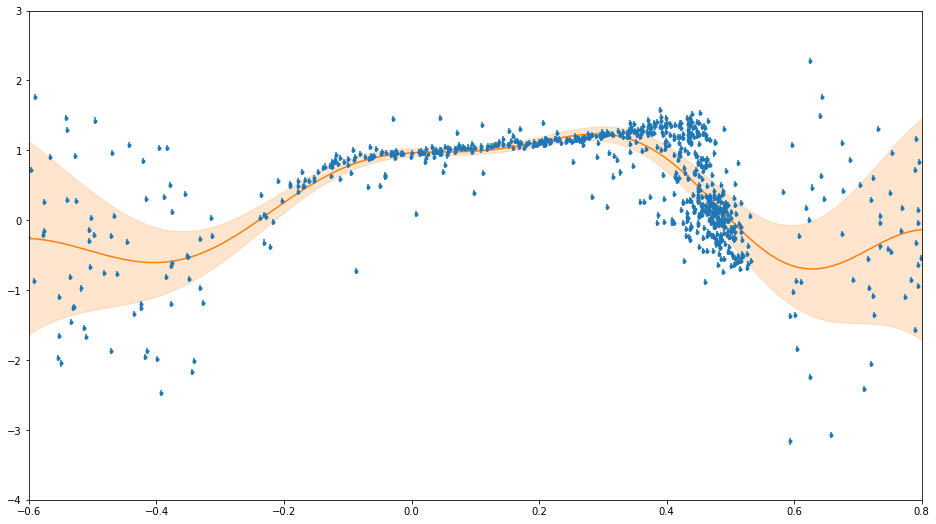

In [622]:
plt.figure(figsize=(16, 9))
plt.errorbar(logbprp, logp, yerr=logp_err, fmt=".");
plt.plot(x, model(results.x, x))

mean, var = model(results.x, x), variance(results.x, x, np.ones_like(x)*.1);
plt.fill_between(x, mean + var, mean - var, alpha=.2, color="C1");
plt.xlim(-.6, .8)
plt.ylim(-4, 3)

(-0.6, 0.8)

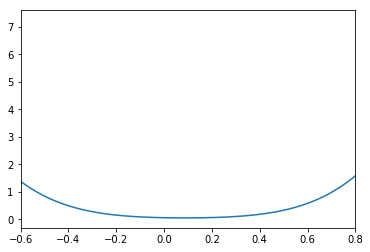

In [623]:
plt.plot(x, var)
plt.xlim(-.6, .8)

Now make up some data that allows you to have a smoothly increasing variance for EEP.

In [624]:
neep = 100
bprp, period = np.log10(pr.bp[m] - pr.rp[m]), np.log10(pr.prot[m])
cut = 4.2
subgiant_eeps = np.random.uniform(cut, 6, neep)
eeps = np.concatenate((np.random.uniform(2, cut, len(logbprp)), subgiant_eeps))
eep_prot = np.concatenate((np.zeros(len(logp))+np.random.randn(len(logp))*.05, 
                           np.random.randn(neep)*(1.5*subgiant_eeps-cut)))

def eep_model(p, x):
    return np.zeros(len(x))

def eep_variance(p, x, yerr):
    return (yerr + np.polyval(p, x))**2
            
def eep_nll(p, x, y, yerr):
    mod = eep_model(p, x)
    var = eep_variance(p, x, yerr)
    return np.sum((-.5 * (mod - y)**2/var - .5*np.log(2*np.pi*var)))*-1

eep_p0 = 1e-2*np.ones(4)

yerr = logp_err * np.ones_like(eep_prot)

[ 0.20065085 -1.66620306  4.53343532 -4.02297299]


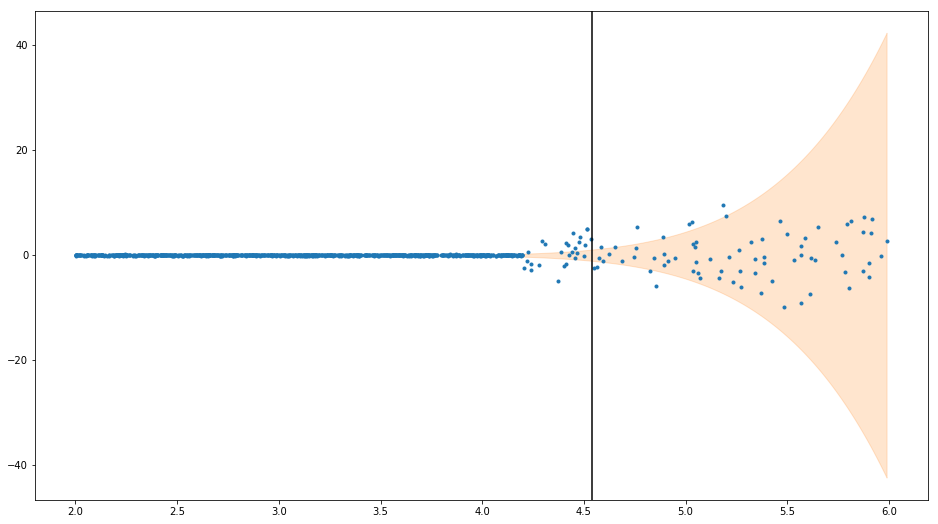

In [625]:
eep_results = sco.minimize(eep_nll, eep_p0, args=(eeps, eep_prot, yerr))
print(eep_results.x)

eep_mean = eep_model(eep_results.x, eep_x)
eep_var = eep_variance(eep_results.x, eep_x, yerr)

plt.figure(figsize=(16, 9))
plt.plot(eeps, eep_prot, ".")
plt.fill_between(eep_x, eep_mean + eep_var, eep_mean - eep_var, alpha=.2, color="C1");
plt.axvline(4.54, color="k")

(0, 60)

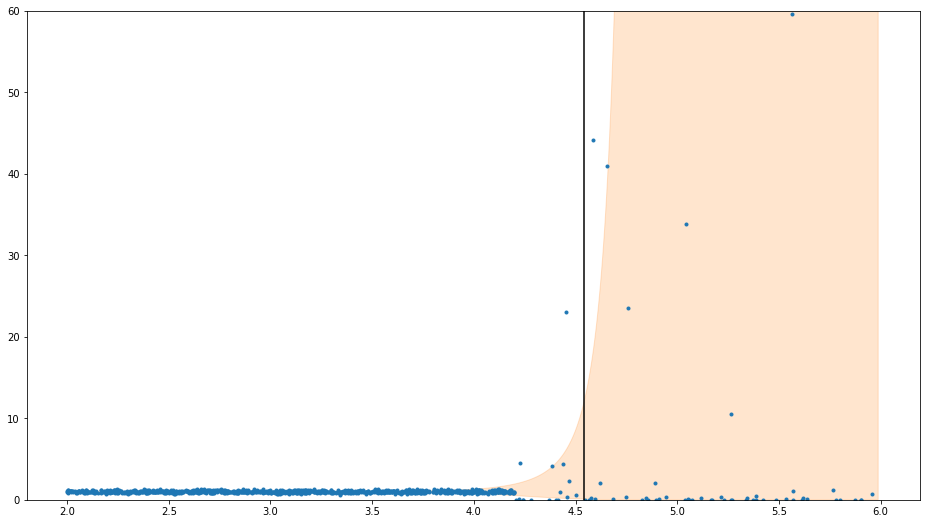

In [626]:
plt.figure(figsize=(16, 9))
plt.plot(eeps, 10**eep_prot, ".")
plt.fill_between(eep_x, 10**(eep_mean + eep_var), 10**(eep_mean - eep_var), alpha=.2, color="C1");
plt.axvline(4.54, color="k")
plt.ylim(0, 60)

Simulate stars from this model to check that things look reasonable.

In [668]:
best_fit = np.concatenate((results.x, eep_results.x))

def total_variance(p, color, eep, period_err):
    z = eep/100.
    return (period_err + np.polyval(p[20:23], color) + np.polyval(p[23:], eep))**2

def generative_model(p, color, eep, period_err):
    z = eep/100.
    mean = model(p, color)
    var = total_variance(p, color, z, period_err)
    return mean + np.random.randn(len(color))*var

def gyro_model(log10_age, log_c, params):
    age_gyr = (10**log10_age)*1e-9
    log_age_gyr = np.log10(age_gyr)
    return np.polyval(params[:20], log_c)

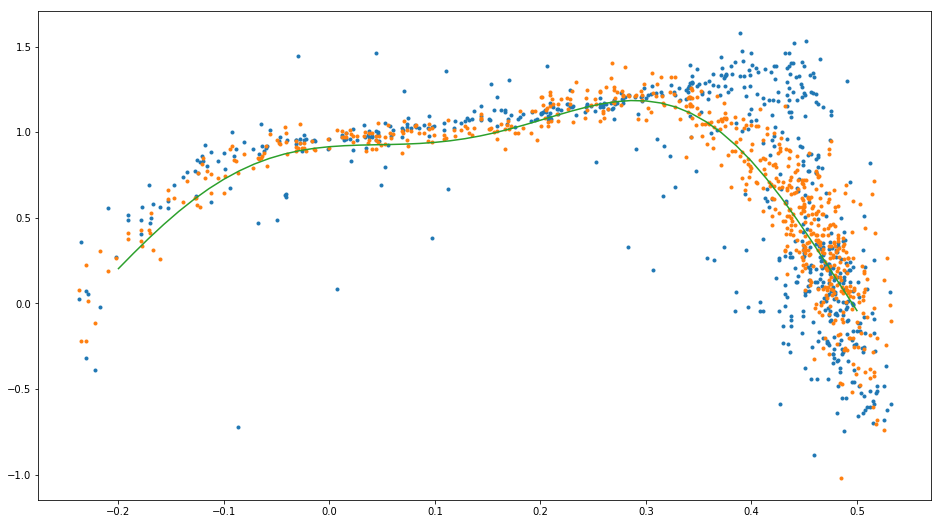

In [669]:
plt.figure(figsize=(16, 9))
plt.plot(bprp, period, ".")
dwarfs = generative_model(best_fit, bprp, np.ones_like(bprp)*250, logp_err)
plt.plot(bprp, dwarfs, ".")
plt.plot(np.linspace(-.2, .5), gyro_model(np.log10(650*1e6), np.linspace(-.2, .5), best_fit))

Now add the weakened magnetic braking.